In [1]:
import numpy as np
import gzip
import tensorflow as tf

import data_access as data
import bidding

from tqdm import tqdm

In [98]:
reader = data.load_deals(gzip.open('../deals_0001.gz'))
#X, contracts = next(reader)

In [3]:
n_bids = len(bidding.BID2ID)

num_steps = 32
lstm_size = 512

lstm = tf.nn.rnn_cell.BasicLSTMCell(lstm_size)

x_in = tf.placeholder(tf.float32, [1, 2 + 3*n_bids + 52], 'x_in')

state_c = tf.placeholder(tf.float32, [1, lstm.state_size.c], 'state_c')
state_h = tf.placeholder(tf.float32, [1, lstm.state_size.h], 'state_h')

init_c = np.zeros((1, lstm.state_size.c))
init_h = np.zeros((1, lstm.state_size.h))

softmax_w = tf.get_variable('softmax_w', shape=[lstm.output_size, n_bids], dtype=tf.float32, initializer=tf.contrib.layers.xavier_initializer(seed=1337))
#softmax_b = tf.Variable(np.zeros((1, n_bids)), dtype=tf.float32)

In [4]:
output, (next_c, next_h) = lstm(x_in, (state_c, state_h))
out_bid = tf.nn.softmax(tf.matmul(output, softmax_w))

In [5]:
seq_in = tf.placeholder(tf.float32, [1, None, 2 + 3*n_bids + 52], 'seq_in')

target = tf.placeholder(tf.float32, [1, None, 40], 'target')

In [6]:
out_dyn, _ = tf.nn.dynamic_rnn(lstm, seq_in, initial_state=lstm.zero_state(1, tf.float32))

In [7]:
out_bid_dyn_logit = tf.matmul(tf.reshape(out_dyn, [-1, lstm_size]), softmax_w)
#out_bid_dyn = tf.nn.softmax(out_bid_dyn_logit)

In [8]:
cost = tf.losses.softmax_cross_entropy(tf.reshape(target, [-1, 40]), out_bid_dyn_logit)

In [9]:
train_step = tf.train.MomentumOptimizer(learning_rate=0.001, momentum=0.9).minimize(cost)
#train_step = tf.train.GradientDescentOptimizer(learning_rate=0.001).minimize(cost)

In [10]:
sess = tf.InteractiveSession()

sess.run(tf.global_variables_initializer())

In [11]:
def model(sess):
    def fun(x_input, s_c, s_h):
        out_bid_np, next_c_np, next_h_np = sess.run([out_bid, next_c, next_h], feed_dict={x_in: x_input, state_c: s_c, state_h: s_h})
        return out_bid_np, next_c_np, next_h_np
    return fun

In [12]:
def create_input_output_sequence(auction, X):
    target_seq = []
    input_seq = []
    for i, bid in enumerate(auction):
        if bid == 'PAD_START':
            continue
        start_ix = max(0, i - 3)
        end_ix = i
        prev_bids = auction[start_ix:end_ix]
        prev_bids = ['PAD_START'] * max(0, 3 - len(prev_bids)) + prev_bids
        assert len(prev_bids) == 3
        target_seq.append(bidding.encode_bid(bid))
        hand_ix = i % 4
        input_seq.append(bidding.get_input(prev_bids[0], prev_bids[1], prev_bids[2], X[0,:,:,hand_ix].reshape((1, 52)), False, False))
    
    sequence_len = len([bid for bid in auction if bid != 'PAD_START'])
    
    return np.concatenate(input_seq).reshape((1, sequence_len, 174)), np.concatenate(target_seq).reshape((1, sequence_len, 40))

In [99]:
costs = []
for _ in range(100):
    for i in tqdm(range(1000)):
        X, contracts, deal_str = next(reader)
        simulator = bidding.Simulator(X, contracts, model(sess))
        score, auction = simulator.best_auction(['PAD_START'] * (i % 4), init_c, init_h, 10)
        if i == 0:
            print(deal_str)
            print(simulator.par, score, auction)
        input_seq_np, target_seq_np = create_input_output_sequence(auction, X)
        c = sess.run(cost, feed_dict={seq_in: input_seq_np, target: target_seq_np})
        costs.append(c)
        sess.run(train_step, feed_dict={seq_in: input_seq_np, target: target_seq_np})
    print(np.mean(costs[-100:]))


  0%|          | 1/1000 [00:00<06:36,  2.52it/s]

SK76 H965 DQ63 C9854  SAT83 HAJ DJ9754 C73  SQ42 H84 DT2 CAKQT62  SJ95 HKQT732 DAK8 CJ
4SE -420.0 ['PASS', 'PASS', '1S', '4H', 'PASS', 'PASS', 'PASS']



  2%|▏         | 23/1000 [00:06<04:19,  3.77it/s]
Exception in thread Thread-401:
Traceback (most recent call last):
  File "/home/ldali/anaconda2/envs/tsflow/lib/python3.5/threading.py", line 914, in _bootstrap_inner
    self.run()
  File "/home/ldali/anaconda2/envs/tsflow/lib/python3.5/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/ldali/anaconda2/envs/tsflow/lib/python3.5/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration

  0%|          | 1/1000 [00:00<02:46,  6.00it/s]

0.953738
S753 HA5 DKJ865 CA62  SAKT942 HQ973 D7 CQ7  SQ86 HKJ8 D9432 CJ85  SJ HT642 DAQT CKT943
3HE 50.0 ['3D', 'PASS', 'PASS', 'PASS']


 20%|██        | 203/1000 [00:48<03:11,  4.16it/s]

KeyboardInterrupt: 

In [80]:
%matplotlib inline

In [81]:
import matplotlib.pyplot as plt

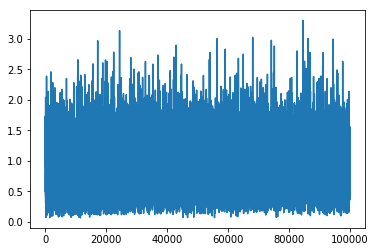

In [82]:
plt.plot(costs)

In [83]:
reader = data.load_deals(gzip.open('../testdata.gz'))
X, contracts, deal_str = next(reader)

In [84]:
print(deal_str)

ST7 HQ DA42 CAKT9872  S92 HK9864 DJ63 CQ53  SAQJ854 HAJ7 DKQ5 C4  SK63 HT532 DT987 CJ6


In [85]:
simulator.simulate_auction([], init_c, init_h)

['2C', '2D', '2H', 'PASS', 'PASS', 'PASS']

In [86]:
simulator = bidding.Simulator(X, contracts, model(sess))

In [87]:
simulator.simulate_auction([], init_c, init_h)

['1H', 'PASS', 'PASS', '3D', '4S', 'PASS', 'PASS', 'PASS']

In [88]:
simulator.par

'6NN'

In [93]:
simulator.best_auction([], init_c, init_h, 10)

(-480.0, ['3N', '4H', '4S', 'PASS', 'PASS', 'PASS'])

In [94]:
def simbid(X, auction, s_c, s_h):
    i = len(auction) % 4
    padded_auction = (['PAD_START'] * max(0, 3 - len(auction))) + auction
    # TODO: fix vulnerability
    x_input = bidding.get_input(padded_auction[-3], padded_auction[-2], padded_auction[-1], X[0,:,:,i].reshape((1, 52)), False, False)
    out_bid_np, next_c_np, next_h_np = simulator.model(x_input, s_c, s_h)
    print(out_bid_np)
    bid_id = np.argmax(out_bid_np)
    bid = bidding.ID2BID[bid_id]
    return bid, next_c_np, next_h_np

In [95]:
auction = []
s_c, s_h = init_c, init_h
while not bidding.auction_over(auction):
    bid, s_c, s_h = simbid(X, auction, s_c, s_h)
    auction.append(bid)

[[  9.58196833e-05   7.93398285e-05   1.33776665e-01   1.02012411e-04
    9.86294326e-05   6.10526428e-02   3.95981856e-02   2.52459981e-02
    4.61201034e-02   7.40215778e-02   1.52882531e-01   4.76094149e-02
    2.41101589e-02   1.12974057e-02   4.71440202e-04   1.83151811e-01
    7.73567185e-02   1.05297565e-03   3.67060682e-04   1.10802889e-01
    1.60858413e-04   1.80896939e-04   2.44556065e-03   5.86882047e-03
    2.20873728e-04   1.42421617e-04   1.05163948e-04   1.17016491e-04
    1.18601296e-04   1.33331123e-04   1.30505534e-04   1.52630790e-04
    1.56978072e-04   1.24531682e-04   1.31143956e-04   1.04028397e-04
    1.11257075e-04   1.00382211e-04   1.08157350e-04   9.35365752e-05]]
[[  1.73277294e-06   2.31789727e-06   6.56303108e-01   2.73879800e-06
    1.41438295e-06   6.77960517e-04   7.72021129e-04   4.06291708e-03
    1.50470866e-03   2.82233139e-03   5.53034013e-03   7.73780234e-03
    3.21504511e-02   6.51600712e-04   1.09807233e-05   1.15390047e-02
    6.67134067e-03

In [96]:
auction

['3C', 'PASS', '4S', 'PASS', 'PASS', 'PASS']

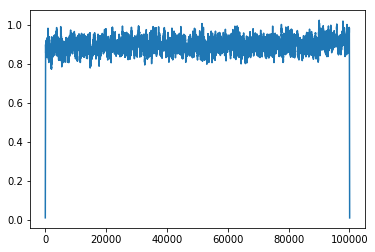

In [97]:
plt.plot(np.convolve(costs, np.ones((100,))/100))

In [101]:
saver = tf.train.Saver()

In [102]:
saver.save?